# Indice de Mercados finacieros

Lucho Sep

#Pasos para crear un modelo VAR con series temporales multivariantes:

1. Análisis exploratorios de los datos.
2. Dividir la serie en conjuntos de entrenamiento y prueba.
3. Prueba de estacionariedad.
4. Transformar la serie de entrenamiento si es necesario. 
5. Construir un modelo VAR sobre las series transformadas.
6. Causalidad de Granger.
7. Diagnóstico del modelo.
8. Realizar pronósticos utilizando el modelo finalmente elegido.
9. Transformación inversa del pronóstico a la escala original.
10. Realizar una evaluación del pronóstico.

# Los datos: EuIndices
Vamos a importar el dataset EuIndices.csv que contiene datos de índices europeos desde el año 1991 hasta 1998. Contiene los índices de DAX (alemán), SMI (suizo), CAC (francés) y FTSE (británico).


## Import librarys

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.graphics.tsaplots as sgt

## Import Dataset

In [91]:
import pandas as pd
EuStocks = pd.read_csv("EuIndices.csv")
EuStocks.head()

,Unnamed: 0,DAX,SMI,CAC,FTSE
0,1,1628.75,1678.1,1772.8,2443.6
1,2,1613.63,1688.5,1750.5,2460.2
2,3,1606.51,1678.6,1718.0,2448.2
3,4,1621.04,1684.1,1708.1,2470.4
4,5,1618.16,1686.6,1723.1,2484.7


In [92]:
# Arreglando el índice de la serie 
df_comp = pd.DataFrame(data = EuStocks.values, 
                           columns = ['0', 'DAX', 'SMI', 'CAC', 'FTSE'], 
                           index = pd.DatetimeIndex(pd.date_range(start="1991-01-01",periods = 1860, freq = 'B')))
df_comp = df_comp.drop(columns = ['0'])
df_comp.head(10)

,DAX,SMI,CAC,FTSE
1991-01-01,1628.75,1678.1,1772.8,2443.6
1991-01-02,1613.63,1688.5,1750.5,2460.2
1991-01-03,1606.51,1678.6,1718.0,2448.2
1991-01-04,1621.04,1684.1,1708.1,2470.4
1991-01-07,1618.16,1686.6,1723.1,2484.7
1991-01-08,1610.61,1671.6,1714.3,2466.8
1991-01-09,1630.75,1682.9,1734.5,2487.9
1991-01-10,1640.17,1703.6,1757.4,2508.4
1991-01-11,1635.47,1697.5,1754.0,2510.5
1991-01-14,1645.89,1716.3,1754.3,2497.4


In [93]:
df_comp.isnull().sum()

DAX     0
SMI     0
CAC     0
FTSE    0
dtype: int64

In [94]:
df_comp.isna().sum()

DAX     0
SMI     0
CAC     0
FTSE    0
dtype: int64

### Analisis Exploratorio de datos (EDA)

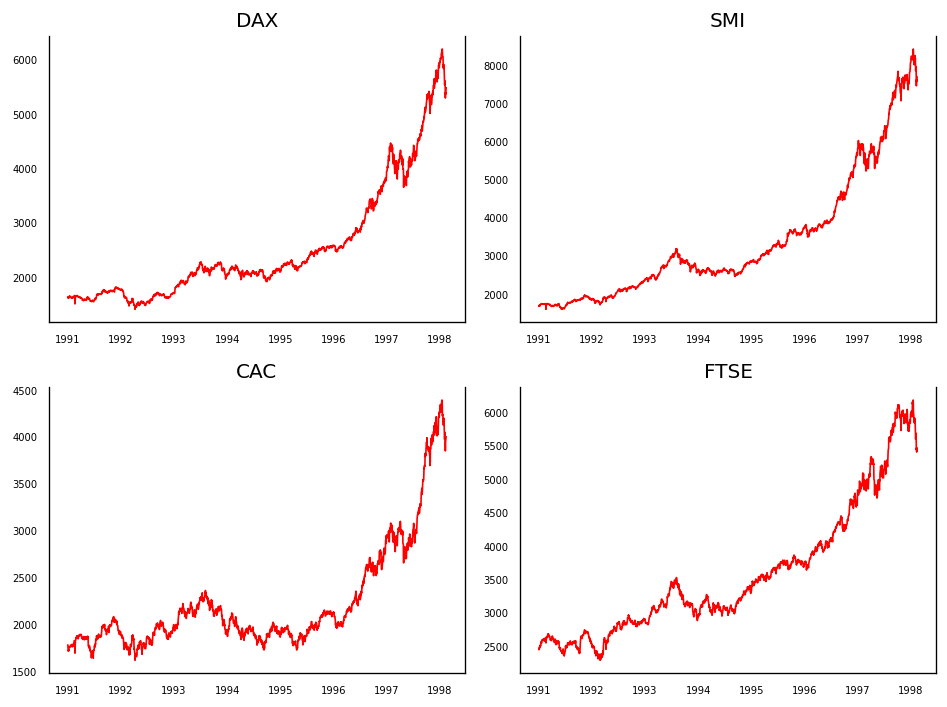

In [95]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(8,6))
for i, ax in enumerate(axes.flatten()):
 data = df_comp[df_comp.columns[i]]
 ax.plot(data, color='red', linewidth=1)
 ax.set_title(df_comp.columns[i])
 ax.xaxis.set_ticks_position('none')
 ax.yaxis.set_ticks_position('none')
 ax.spines['top'].set_alpha(0)
 ax.tick_params(labelsize=6)
 plt.tight_layout();

In [96]:
corr=df_comp.corr()
corr

,DAX,SMI,CAC,FTSE
DAX,1.000000,0.991154,0.966227,0.975178
SMI,0.991154,1.000000,0.946814,0.989969
CAC,0.966227,0.946814,1.000000,0.915726
FTSE,0.975178,0.989969,0.915726,1.000000


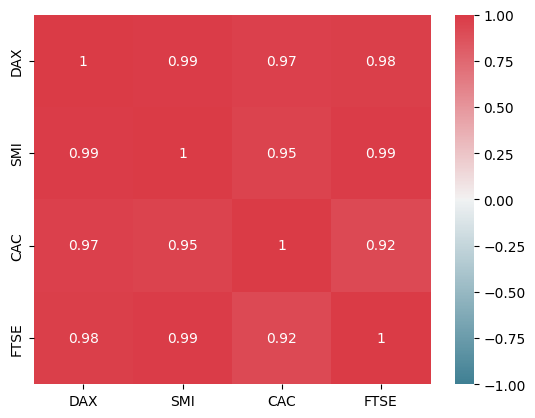

In [97]:
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sns.diverging_palette(220, 10, as_cmap=True),center=0 )
plt.show()

# Dividir los datos en conjunto de Entrenamiento y Prueba
El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.

In [98]:
n_obs=9
X_train, X_test = df_comp[0:-n_obs], df_comp[-n_obs:]
print(X_train.shape, X_test.shape)

(1851, 4) (9, 4)


# Prueba de estacionariedad
Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [99]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
print('Serie de tiempo DAX')
augmented_dickey_fuller_statistics(X_train['DAX'])
print('Serie de tiempo SMI')
augmented_dickey_fuller_statistics(X_train['SMI'])
print('Serie de tiempo CAC')
augmented_dickey_fuller_statistics(X_train['CAC'])
print('Serie de tiempo FTSE')
augmented_dickey_fuller_statistics(X_train['FTSE'])


Test de Dickey-Fuller Aumentado:
Serie de tiempo DAX
p-value: 1.000000
Serie de tiempo SMI
p-value: 1.000000
Serie de tiempo CAC
p-value: 0.998487
Serie de tiempo FTSE
p-value: 0.992831


Todos los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

# Transformación de los datos
La aplicación de la primera diferenciación en el conjunto de entrenamiento debería hacer que todas las series 6 sean estacionarias. Sin embargo, este es un proceso iterativo en el que, después de la primera diferenciación, es posible que la serie siga siendo no estacionaria. Tendremos que aplicar una segunda diferencia o transformación logarítmica para estandarizar la serie en tales casos.

In [100]:
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,DAX,SMI,CAC,FTSE
1991-01-02,-15.12,10.4,-22.3,16.6
1991-01-03,-7.12,-9.9,-32.5,-12.0
1991-01-04,14.53,5.5,-9.9,22.2
1991-01-07,-2.88,2.5,15.0,14.3
1991-01-08,-7.55,-15.0,-8.8,-17.9


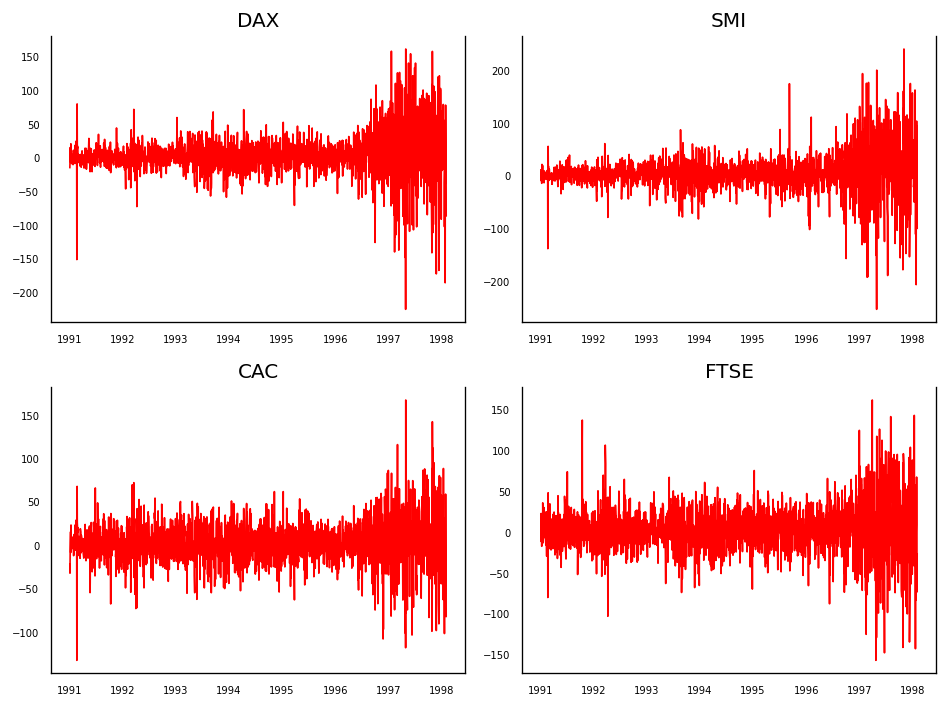

In [101]:
# Dibujemos los datos transformados
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(8,6))
for i, ax in enumerate(axes.flatten()):
  d = X_train_transformed[X_train_transformed.columns[i]]
  ax.plot(d, color='red', linewidth=1)
  ax.set_title(df_comp.columns[i])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  ax.spines['top'].set_alpha(0)
  ax.tick_params(labelsize=6)
  plt.tight_layout();

Chequeando si los datos transformados (diferenciados) son estacionarios:

In [102]:
print('Test de Dickey-Fuller Aumentado:')
print('Serie de tiempo DAX Diferenciada')
augmented_dickey_fuller_statistics(X_train_transformed['DAX'])
print('Serie de tiempo SMI Diferenciada')
augmented_dickey_fuller_statistics(X_train_transformed['SMI'])
print('Serie de tiempo CAC Diferenciada')
augmented_dickey_fuller_statistics(X_train_transformed['CAC'])
print('Serie de tiempo FTSE Diferenciada')
augmented_dickey_fuller_statistics(X_train_transformed['FTSE'])

Test de Dickey-Fuller Aumentado:
Serie de tiempo DAX Diferenciada
p-value: 0.000000
Serie de tiempo SMI Diferenciada
p-value: 0.000000
Serie de tiempo CAC Diferenciada
p-value: 0.000000
Serie de tiempo FTSE Diferenciada
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con un solo orden de diferenciación se obtienen series estacionarias.

# Modelo VAR
VAR requiere la estacionariedad de la serie, lo que significa que la media de la serie no cambia con el tiempo (podemos verlo en el gráfico dibujado junto a la Prueba de Dickey-Fuller aumentada).

In [103]:
model = VAR(X_train_transformed)

## Seleccionando el orden del modelo

In [104]:
modelsel=model.select_order(15)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,25.21,25.22*,8.857e+10,25.21
1,25.17,25.23,8.523e+10,25.19*
2,25.17,25.28,8.566e+10,25.21
3,25.16,25.32,8.461e+10,25.22
4,25.15,25.36,8.405e+10,25.23
5,25.15,25.41,8.392e+10,25.25
6,25.15,25.45,8.381e+10,25.26
7,25.15,25.50,8.397e+10,25.28
8,25.16,25.55,8.429e+10,25.30
9,25.15*,25.59,8.364e+10*,25.31


## Ajustando el modelo

In [105]:
res = model.fit(maxlags=15, ic='aic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 02, Sep, 2023
Time:                     18:02:34
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    25.5838
Nobs:                     1841.00    HQIC:                   25.3038
Log likelihood:          -33442.6    FPE:                8.28436e+10
AIC:                      25.1402    Det(Omega_mle):     7.65054e+10
--------------------------------------------------------------------
Results for equation DAX
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           2.397394         0.760698            3.152           0.002
L1.DAX          0.010837         0.041515            0.261           0.794
L1.SMI         -0.108377         0.029725           -3.646           0.000
L1.CAC     

# Causalidad de Granger

Si el p-valor < 0.05 Rechazo la hipótesis nula H0 y mantengo la variable dentro del modelo.

### DAX

In [106]:
grangercaus=res.test_causality(['SMI', 'CAC', 'FTSE'],['DAX'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.745,1.487,0.010,"(27, 7216)"


### SMI

In [107]:
grangercaus=res.test_causality(['DAX', 'CAC', 'FTSE'],['SMI'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.530,1.487,0.000,"(27, 7216)"


### CAC

In [108]:
grangercaus=res.test_causality(['DAX', 'SMI', 'FTSE'],['CAC'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.818,1.487,0.006,"(27, 7216)"


### FTSE

In [109]:
grangercaus=res.test_causality(['DAX', 'SMI', 'CAC'],['FTSE'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.090,1.487,0.001,"(27, 7216)"


# Matriz de causalidad de Granger

In [110]:
maxlag=15
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose: 
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

C:\Users\Luciano\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Luciano\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Luciano\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


C:\Users\Luciano\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Luciano\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Luciano\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Luciano\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Luciano\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Luciano\AppData\Roami

,DAX_x,SMI_x,CAC_x,FTSE_x
DAX_y,1.0000,0.0001,0.0000,0.0012
SMI_y,0.0004,1.0000,0.0002,0.0000
CAC_y,0.0026,0.0148,1.0000,0.0007
FTSE_y,0.0473,0.0000,0.0014,1.0000


# Diagnosis del modelo

## Residuos

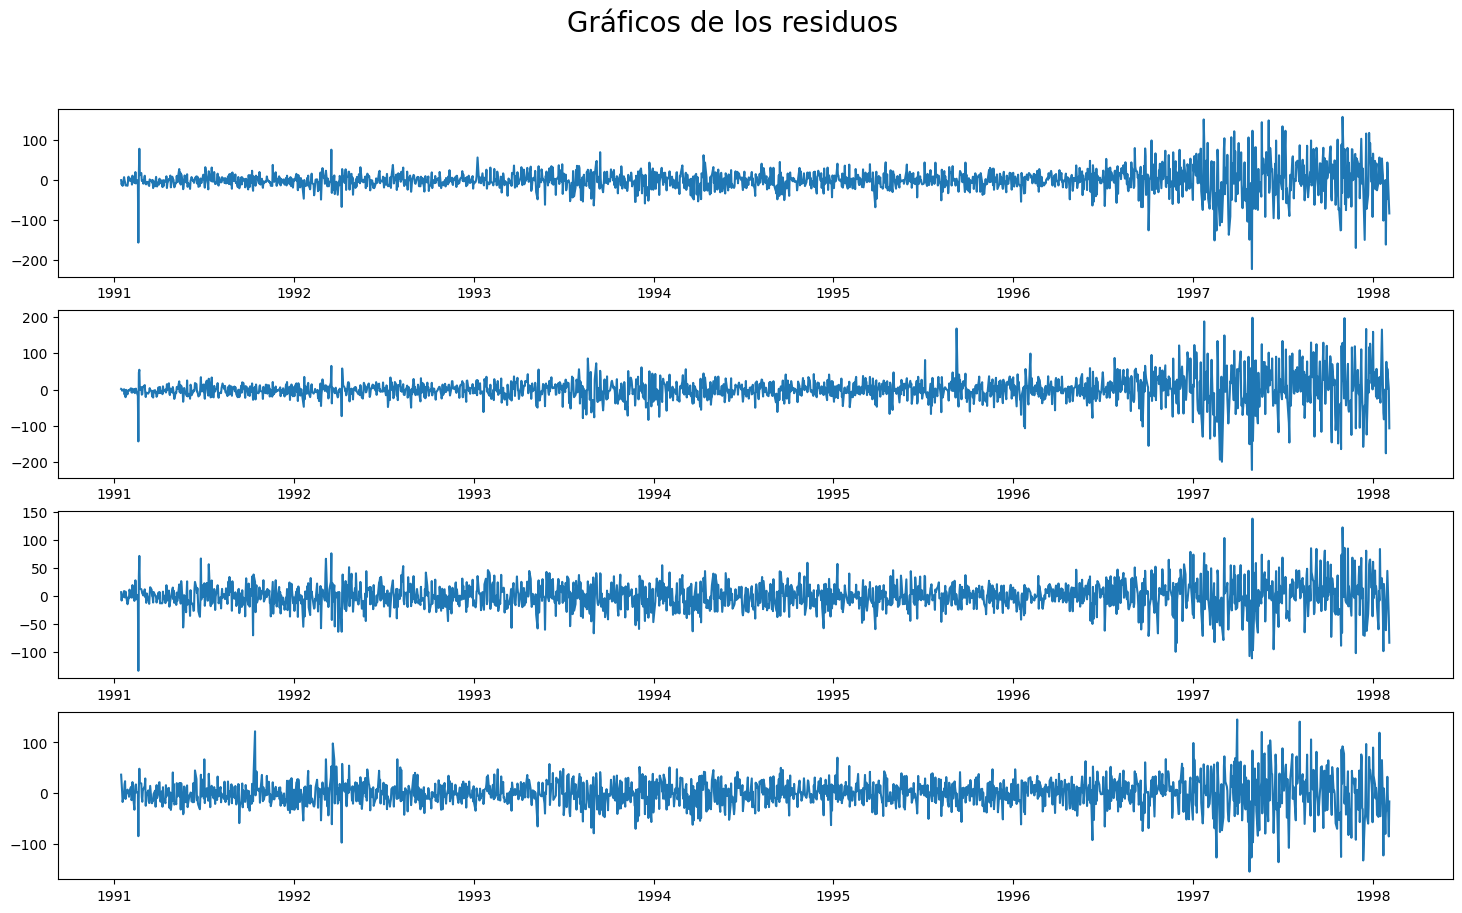

In [111]:
residuals=res.resid

fig, axs = plt.subplots(4)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(4)]
plt.show()

## Dickey - Fuller a los residuos

In [112]:
print('DAX SMI CAC FTSE')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(4)]

DAX SMI CAC FTSE


[1.148610671664592e-13, 0.0, 0.0, 0.0]

Todos los p-valores son < 0.05 por tanto se rechaza la hipótesis nula de que las 4 series de residuos no son estacionarias, por lo cual con un 95% de confianza se cree que son estacionarias. 

## ACF de los Residuos

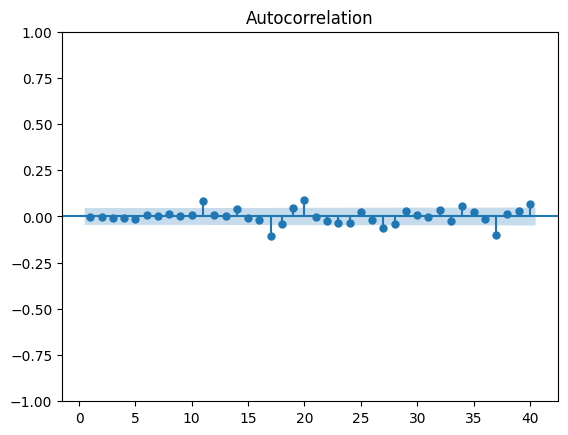

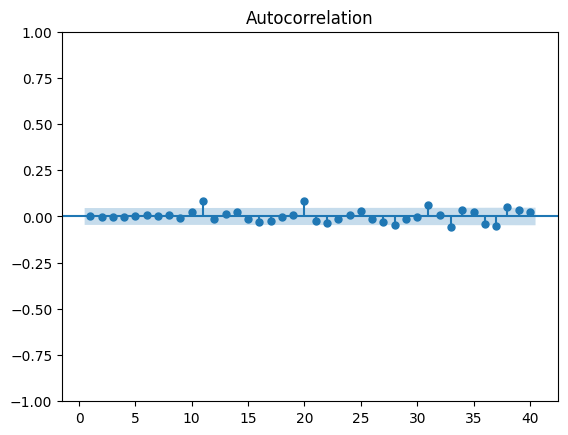

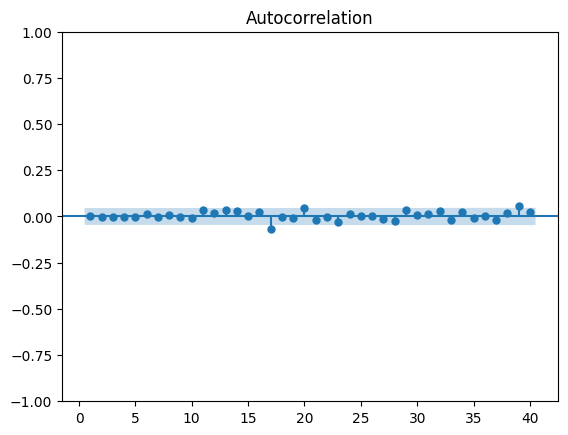

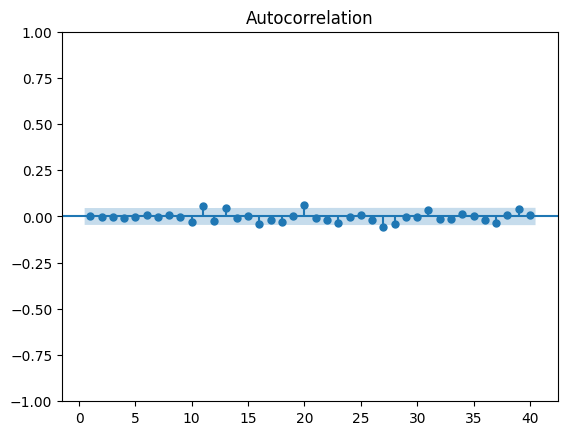

In [113]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 40) for i in range(4)]
plt.show()


Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.

## Valores predichos

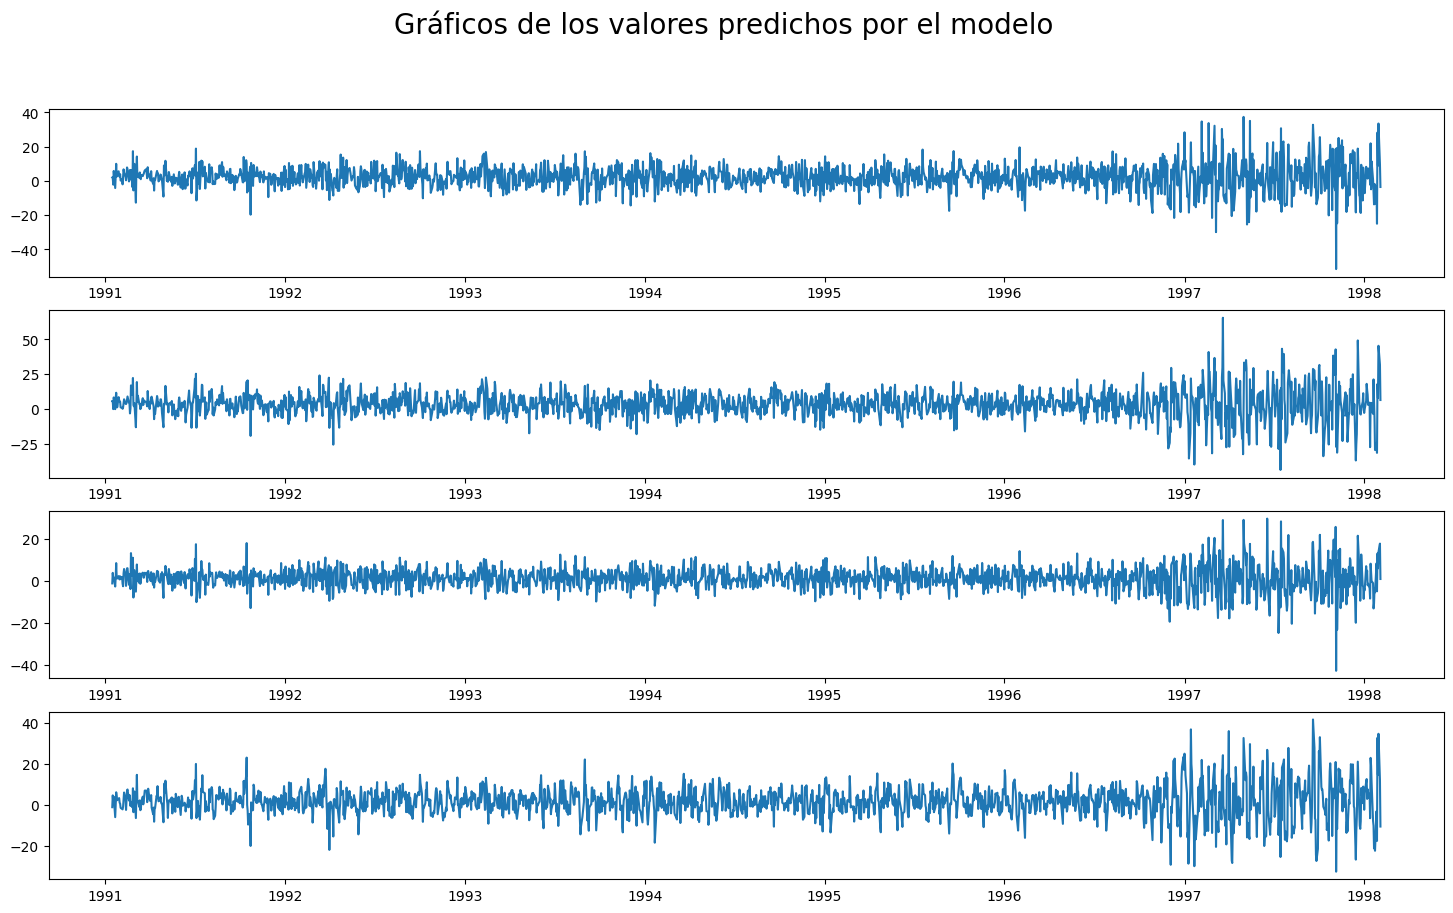

In [114]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(4)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(4)]
plt.show()

# Pronósticos a futuro

## Hallando los pronósticos

Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.

In [115]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 9
Predicciones:


,DAX_pred,SMI_pred,CAC_pred,FTSE_pred
1998-02-04,-11.643732,-5.965373,4.860743,-3.356239
1998-02-05,-8.315970,-13.814023,-7.340432,-6.684401
1998-02-06,4.705067,5.008977,12.389846,15.701406
1998-02-09,0.671762,3.669608,1.384590,2.627523
1998-02-10,7.798028,5.258018,4.226443,10.711556
1998-02-11,8.939204,11.561625,2.489899,8.471433
1998-02-12,9.815429,15.938717,-0.474356,4.048867
1998-02-13,3.601746,-7.931211,1.744192,0.578008
1998-02-16,-8.224879,-4.786278,-2.740389,-5.979835


<Figure size 1200x1000 with 0 Axes>

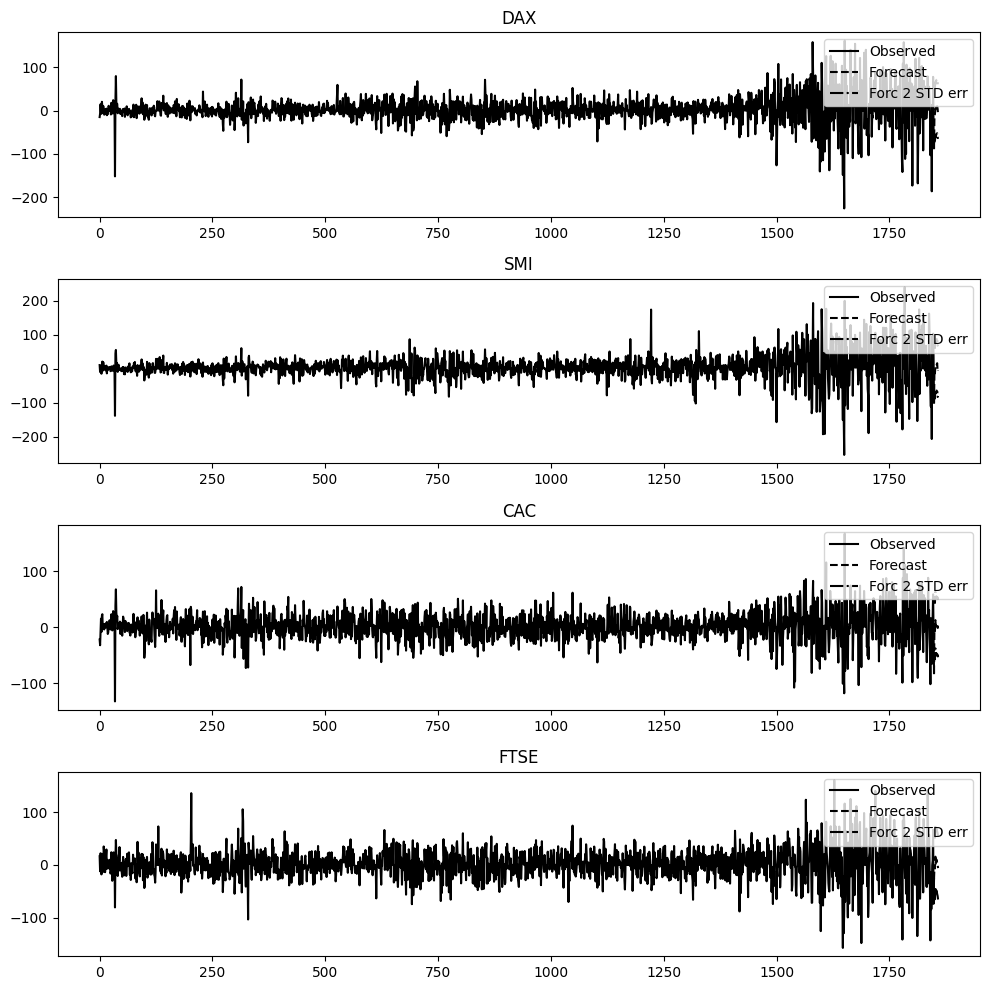

In [116]:
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()

## Invirtiendo la transformación de los pronósticos a la escala original

Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos.
La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base.
Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)

In [117]:
def invert_transformation(X_train, pred):
  forecast = pred.copy()
  columns = X_train.columns
  for col in columns:
    forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
  return forecast

output = invert_transformation(X_train, pred)
output

,DAX_pred,SMI_pred,CAC_pred,FTSE_pred
1998-02-04,5762.736268,8133.234627,4099.860743,5806.343761
1998-02-05,5754.420297,8119.420604,4092.520311,5799.659360
1998-02-06,5759.125364,8124.429581,4104.910157,5815.360766
1998-02-09,5759.797126,8128.099189,4106.294747,5817.988289
1998-02-10,5767.595153,8133.357207,4110.521190,5828.699845
1998-02-11,5776.534357,8144.918831,4113.011088,5837.171278
1998-02-12,5786.349787,8160.857548,4112.536732,5841.220145
1998-02-13,5789.951532,8152.926337,4114.280924,5841.798153
1998-02-16,5781.726653,8148.140059,4111.540535,5835.818317


## Pronósticos de DAX

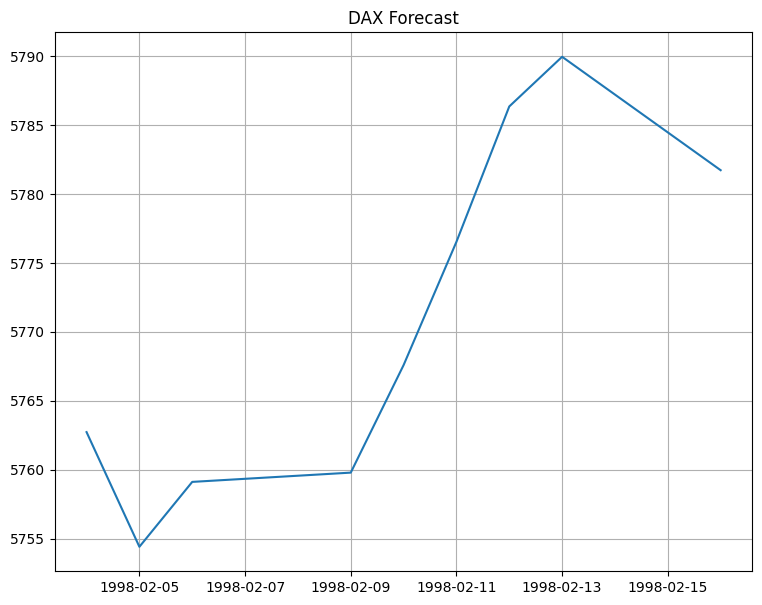

In [118]:
plt.figure(figsize = (9,7))
plt.plot(output.iloc[:,0])
plt.title('DAX Forecast')
plt.grid()
plt.show()

## Pronósticos 30 días en adelante

In [119]:
pred=res.forecast(X_train_transformed.values, 30)
DAXvalues = pred[:,0]
DAXvalues

array([-11.64373242,  -8.31597029,   4.70506654,   0.67176181,
         7.79802782,   8.93920382,   9.81542922,   3.60174599,
        -8.22487905,   0.25885958,   0.55421185,   2.18464196,
         3.96800753,   4.04792745,   2.82184099,   0.74978304,
         1.7186682 ,   1.53170875,   1.98630689,   2.12590497,
         2.3779285 ,   2.40420328,   2.60712629,   2.33818864,
         2.23861346,   2.15853414,   2.15134508,   2.19672756,
         2.26402645,   2.29354046])

In [120]:
X_train.tail(1)

,DAX,SMI,CAC,FTSE
1998-02-03,5774.38,8139.2,4095.0,5809.7


In [121]:
DeDiff = np.cumsum(DAXvalues) + 5774.38

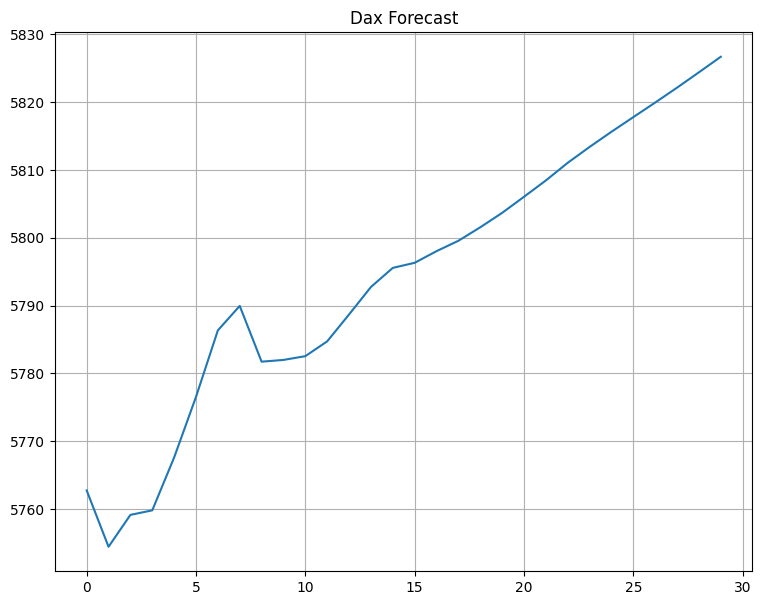

In [122]:
plt.figure(figsize = (9,7))
plt.plot(DeDiff)
plt.title('Dax Forecast')
plt.grid()
plt.show()

In [123]:
# Obtener el orden del modelo
lag_order = 30
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

def invert_transformation(X_train, pred):
  forecast = pred.copy()
  columns = X_train.columns
  for col in columns:
    forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
  return forecast

output = invert_transformation(X_train, pred)
output

Orden del modelo: 30
Predicciones:


,DAX_pred,SMI_pred,CAC_pred,FTSE_pred
1998-02-04,5762.736268,8133.234627,4099.860743,5806.343761
1998-02-05,5754.420297,8119.420604,4092.520311,5799.659360
1998-02-06,5759.125364,8124.429581,4104.910157,5815.360766
1998-02-09,5759.797126,8128.099189,4106.294747,5817.988289
1998-02-10,5767.595153,8133.357207,4110.521190,5828.699845
1998-02-11,5776.534357,8144.918831,4113.011088,5837.171278
1998-02-12,5786.349787,8160.857548,4112.536732,5841.220145
1998-02-13,5789.951532,8152.926337,4114.280924,5841.798153
1998-02-16,5781.726653,8148.140059,4111.540535,5835.818317


In [124]:
# Combinar X_train (datos reales pasados) con las predicciones nuevas
output.columns=['DAX','SMI','CAC','FTSE']
output=output.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)
combineall = pd.concat([X_train, output], axis=0)
combineall=combineall.reset_index(drop=True)
combineall

,DAX,SMI,CAC,FTSE
0,1628.750000,1678.100000,1772.800000,2443.600000
1,1613.630000,1688.500000,1750.500000,2460.200000
2,1606.510000,1678.600000,1718.000000,2448.200000
3,1621.040000,1684.100000,1708.100000,2470.400000
4,1618.160000,1686.600000,1723.100000,2484.700000
...,...,...,...,...
1855,5767.595153,8133.357207,4110.521190,5828.699845
1856,5776.534357,8144.918831,4113.011088,5837.171278
1857,5786.349787,8160.857548,4112.536732,5841.220145
1858,5789.951532,8152.926337,4114.280924,5841.798153


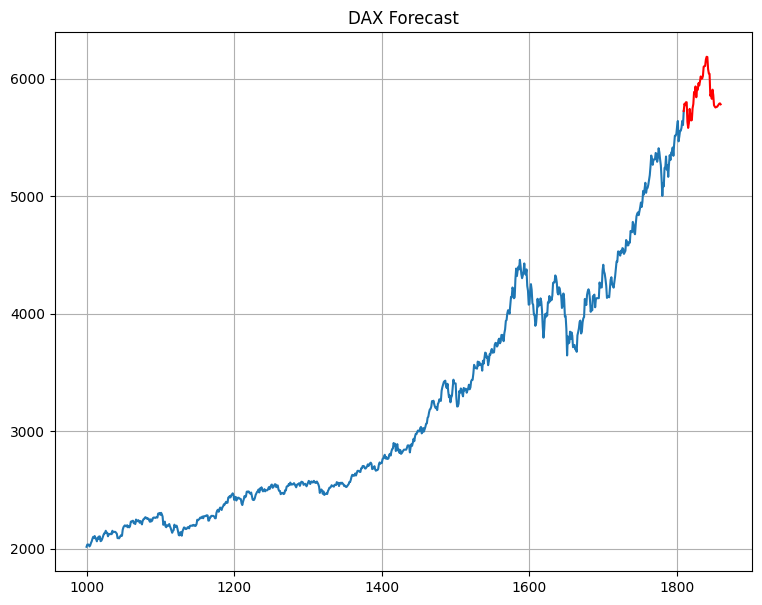

In [125]:
plt.figure(figsize = (9,7))
plt.plot(combineall.iloc[1000:1810,0])
plt.plot(combineall.iloc[1809:1860,0],color='red')
plt.title('DAX Forecast')
plt.grid()
plt.show()

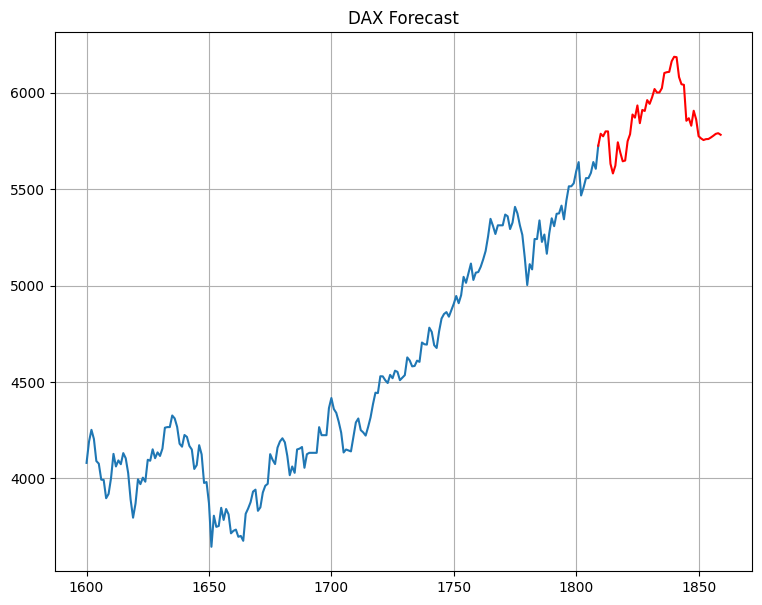

In [126]:
plt.figure(figsize = (9,7))
plt.plot(combineall.iloc[1600:1810,0])
plt.plot(combineall.iloc[1809:1860,0],color='red')
plt.title('DAX Forecast')
plt.grid()
plt.show()